# RNN Zeitreihenvorhersage

### Lernen und vorhersagen von Zeitreihen

Als erstes wird hier alles nötige importiert (wir verwenden hier Tensorflow ohne kein Keras) und ein paar Einstellungen werden vorgenommen:

In [19]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import tensorflow as tf

# Zeitreihen

Zunächst wird eine einfache Zeitreihe (aus Sinusfunktionen) erstellt und in batches aufgeteilt

In [20]:
t_min, t_max = 0, 30
resolution = 0.1

#Die Zeitreihe, die erlernt und vorhergesagt werden soll
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

#Erstellt zufällige batches aus der Zeitreihe
def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

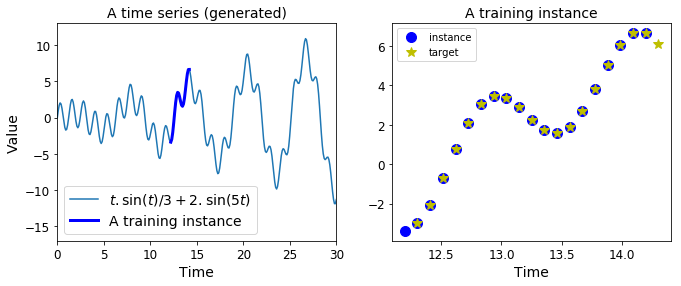

In [21]:
#Plotten der Funktion und der Trainingsdaten
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

Im rechten Plot ist die gesammte Zeitreihe dargestellt. Markiert ist eine zufällige Trainingssequenz.

Im linken Plot ist die Trainingssequenz dargestellt. Die blauen Kreise stellen die Eingaben für das Netz dar. Die gelben Sterne sind die erwarteten Ausgaben, die das Netz liefern soll (das ist jeweils der nächste Datenpunkt der Zeitreihe).

## Trainieren des Netzes

Es wird ein RNN erstellt mit:
- 1 Eingabeneuron (erhällt nur den skalaren Wert für jeden Zeitschritt; es werden 20 Zeitschritte als Eingabe verwendet)
- 100 Rekurente Neuronen als Hidden-Layer
- 1 Ausgabeneuron (das die Ausgabe zum nächsten Zeitpunkt liefern soll)

In [32]:
#mögliche früher erstellte Graphen werden gelöscht
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

learning_rate = 0.001

#Die Placeholder sind in Tensorflow dazu da, die Eingaben (X Matrix) und die Ausgaben (y Vektor) im Graphen zu modellieren
#Die Placeholder werden im Training und in der Ausführung durch die Werte des Datensatzes ersetzt
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

#Hidden-Layer erstellen
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

#loss funktion erstellen (verwendet den Mittleren-Quadratischen-Fehler MSE) und modell trainieren (mit einem AdamsOptimierer)
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [33]:
#zum speichern des modells
saver = tf.train.Saver()

#Das Netz wird über 1500 iterationen trainiert
n_iterations = 1500
batch_size = 50


mse_training = np.empty(n_iterations // 100)

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            mse_training[iteration // 100] = mse
            print(iteration+100, "\tMSE:", mse)
            
    #nach dem trainieren wird das modell gespeichert
    saver.save(sess, "./my_time_series_model")

100 	MSE: 10.261381
200 	MSE: 0.38792896
300 	MSE: 0.10900874
400 	MSE: 0.061354414
500 	MSE: 0.059336416
600 	MSE: 0.058288667
700 	MSE: 0.052280974
800 	MSE: 0.047044784
900 	MSE: 0.049216457
1000 	MSE: 0.0473833
1100 	MSE: 0.047798716
1200 	MSE: 0.047832422
1300 	MSE: 0.041717164
1400 	MSE: 0.046195257
1500 	MSE: 0.04128444


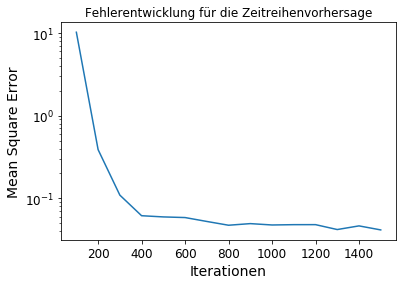

In [34]:
x = [i * 100 + 100 for i in range(len(mse_training))]
plt.semilogy(x, mse_training)
plt.xlabel("Iterationen")
plt.ylabel("Mean Square Error")
plt.title("Fehlerentwicklung für die Zeitreihenvorhersage")
plt.show()

In [35]:
#Erstelltes modell laden und eine vorhersage erzeugen
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


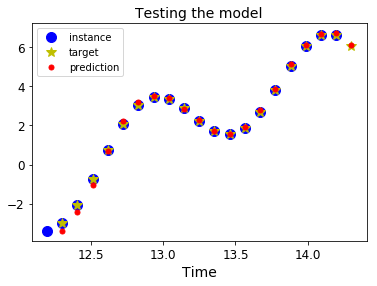

In [37]:
#Vorhersage des modells plotten
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

### Ergebniss der Zeitreihenvorhersage:

In blau sind die Eingaben des Netzes dargestellt. Die Gelben Sterne sind die Erwarteten ausgaben des Netzes und in rot sind die Wirklichen Ausgaben des Netzes dargestellt.

Am Anfang der Zeitreihe ist zu erkennen, dass die Vorhersage noch nicht besonders gut ist (das Netz gibt fast nur den selben Wert aus, den es als Eingabe erhallten hat). Das liegt daran, dass der erste Punkt der Eingabe irgentein Punkt sein kann und das Netz noch keine Informationen über den Verlauf hat.

Die nächsten Punkte werden immer besser getroffen, da das Netz erkennt wie die Eingabesequenz aussieht (zu Beginn war die Eingabe nur ein Skalar und noch keine Sequenz). Nach einigen Eingabedaten kann das Netz erkennen, wie sich die Zeitreihe verhällt und wie sie vermutlich fortgeführt wird.